In [5]:
%load_ext autoreload
%autoreload 2
import os
import sys
from copy import deepcopy
import warnings

from pathlib import Path
import mesmerize_core as mc
import matplotlib.pyplot as plt

import napari
import scanreader
from tifffile import imwrite, imread

import pandas as pd
import numpy as np
import dask.array as da
import zarr
import numpy as np
try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass
from mesmerize_core.caiman_extensions.cnmf import cnmf_cache

if os.name == "nt":
    # disable the cache on windows
    cnmf_cache.set_maxsize(0)

sys.path.append("../../scanreader/")
warnings.filterwarnings("ignore")
os.environ["CONDA_PREFIX_1"] = ""

pd.options.display.max_colwidth = 120

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up data and save-paths

In [2]:
parent = Path('/home/mbo/caiman_data/high_res')
mc.set_parent_raw_data_path(parent)
batch_path = mc.get_parent_raw_data_path().joinpath("mesmerize-batch/batch.pickle")
raw_tiffs = [x for x in parent.glob("*.tif*")]
reader = scanreader.read_scan(str(raw_tiffs[0]), join_contiguous=True)

In [3]:
reader.shape

(1730, 30, 2478, 145)

In [8]:
def trim(scan, amounts_x):
    new_slice_x = [slice(s.start + amounts_x[0], s.stop - amounts_x[1]) for s in scan.fields[0].output_xslices]
    return [i for s in new_slice_x for i in range(s.start, s.stop)]

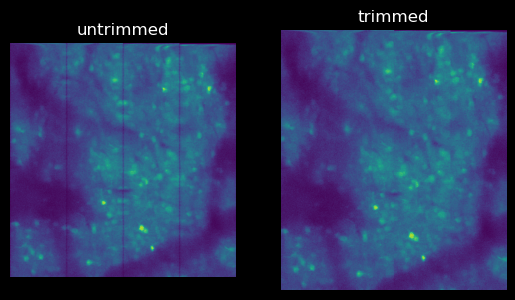

In [14]:
savep = parent / "tiff" 

savep.mkdir(exist_ok=True)

def sp(reader, plane):
    idx = plane - 1
    savename = savep / f"extracted_plane_{plane}_v1.tiff"
    trim_x = trim(reader, (7,7))
    image_og = reader[1, idx, :,:]
    image_trim = reader[1, idx, trim_x, :]
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image_og)
    ax[0].axis('off')
    ax[0].set_title('untrimmed')
    ax[1].imshow(image_trim)
    ax[1].axis('off')
    ax[1].set_title('trimmed')
    plt.show()
    # viewer.add_image(image_og, contrast=[0,1], name=f"image_{plane}", rgb=False)
    # viewer.add_image(image_trim, contrast=[0,1], name=f"image_{plane}", rgb=False)

sp(reader, 1)

In [ ]:
import scanreader
from magicgui import magicgui
from napari import Viewer, gui_qt

# Define the trim function
def trim(scan, amounts_x):
    new_slice_x = [slice(s.start + amounts_x[0], s.stop - amounts_x[1]) for s in scan.fields[0].output_xslices]
    return [i for s in new_slice_x for i in range(s.start, s.stop)]

# Initialize Napari viewer
with gui_qt():
    reader = scanreader.read_scan(str(raw_tiff_name), join_contiguous=True)
    viewer = Viewer()

    @magicgui(
        amounts_x_start={"label": "Trim Start", "widget_type": "IntSlider", "min": 0, "max": 100},
        amounts_x_end={"label": "Trim End", "widget_type": "IntSlider", "min": 0, "max": 100}
    )
    def update_image(amounts_x_start: int = 0, amounts_x_end: int = 0):
        # Load and trim the image
        tx = trim(reader, (amounts_x_start, amounts_x_end))
        trimmed = reader[:, :, tx, 0, 2]

        # Update the viewer with the new image data
        if 'trimmed_image' in viewer.layers:
            viewer.layers['trimmed_image'].data = trimmed
        else:
            viewer.add_image(trimmed, name='trimmed_image', colormap='gray')

    # Connect the sliders to the update function directly
    update_image.amounts_x_start.changed.connect(lambda event: update_image())
    update_image.amounts_x_end.changed.connect(lambda event: update_image())

    # Add the widget to the viewer
    viewer.window.add_dock_widget(update_image, area='right')

    # Initial update
    update_image()

In [ ]:
viewer.close()

### Save as a multi-page tiff

In [ ]:
for idx, plane in enumerate(range(1, reader.num_channels+1)):
    savename = parent / f"extracted_plane_{plane}.tiff"
    trim_x, trim_y = trim(reader, (4,4), (17,0))
    imwrite(savename, reader[:,16:,trim_x,idx,:].squeeze().transpose(2,0,1), photometric='minisblack')


Preview trim result

In [ ]:
with gui_qt():
    viewer = Viewer()
    # viewer.add_image(df.iloc[0].caiman.get_input_movie(), name='input', colormap='gray')
    viewer.add_image(imread(savename),name='output', colormap='gray')

### Save as a zarr store

In [ ]:
# create a new batch
try:
    df = mc.create_batch(batch_path)
except FileExistsError:
    df = mc.load_batch(batch_path)
    
movie_path = savename

In [ ]:
mcorr_params2 =\
{
  'main':
    {
        'max_shifts': [4, 4],
        'strides': [48, 48],
        'overlaps': [24, 24],
        'max_deviation_rigid': 3,
        'border_nan': 'copy',
        'pw_rigid': True,
        'gSig_filt': None
    },
}

# add other param variant to the batch
df.caiman.add_item(
  algo='mcorr',
  item_name=movie_path.stem,
  input_movie_path=movie_path,
  params=mcorr_params2
)

df

In [ ]:
# copy the mcorr_params2 dict to make some changes
new_params = deepcopy(mcorr_params2)

# some variants of max_shifts
for shifts in [2, 32]: 
    for strides in [12, 24, 64]:
        overlaps = int(strides / 2)
        # deep copy is the safest way to copy dicts
        new_params = deepcopy(new_params)

        # assign the "max_shifts"
        new_params["main"]["max_shifts"] = (shifts, shifts)
        new_params["main"]["strides"] = (strides, strides)
        new_params["main"]["overlaps"] = (overlaps, overlaps)

        df.caiman.add_item(
          algo='mcorr',
          item_name=movie_path.stem,
          input_movie_path=movie_path,
          params=new_params
        )

In [ ]:
diffs = df.caiman.get_params_diffs(algo="mcorr", item_name=df.iloc[0]["item_name"])
diffs

In [ ]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip
        
    process = row.caiman.run()
    
    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

In [ ]:
df = df.caiman.reload_from_disk()
df

In [ ]:
movie = df.iloc[6].caiman.get_input_movie()
mean = [df.iloc[6].caiman.get_projection("mean")]

In [ ]:
df

In [ ]:

# first item is just the raw movie
movies = [df.iloc[0].caiman.get_input_movie()]

# subplot titles
subplot_names = ["raw"]

# we will use the mean images later
means = [df.iloc[0].caiman.get_projection("mean")]

# get the param diffs to set plot titles
param_diffs = df.caiman.get_params_diffs("mcorr", item_name=df.iloc[0]["item_name"])

# add all the mcorr outputs to the list
for i, row in df.iterrows():
    # add to the list of movies to plot
    movies.append(row.mcorr.get_output())

    max_shifts = param_diffs.iloc[i]["max_shifts"][0]
    strides = param_diffs.iloc[i]["strides"][0]
    overlaps = param_diffs.iloc[i]["overlaps"][0]
    
    # subplot title to show dataframe index
    subplot_names.append(f"ix {i}: max_sh: {max_shifts}, str: {strides}, ove: {overlaps}")
    
    # mean images which we'll use later
    means.append(row.caiman.get_projection("mean"))

# stack movies using Dask
stacked_movies = da.stack([da.from_array(movie) for movie in movies])



View an example movie

In [ ]:
# create the viewer
viewer = Viewer()
# viewer.add_image(df.iloc[0].caiman.get_input_movie(), name='input', colormap='gray')
viewer.add_image(df.iloc[0].mcorr.get_output(), name='output', colormap='gray')

In [ ]:
shifts = df.iloc[0].mcorr.get_shifts()